In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

Dataset Shape: (569, 32)
First 5 rows:
          id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  

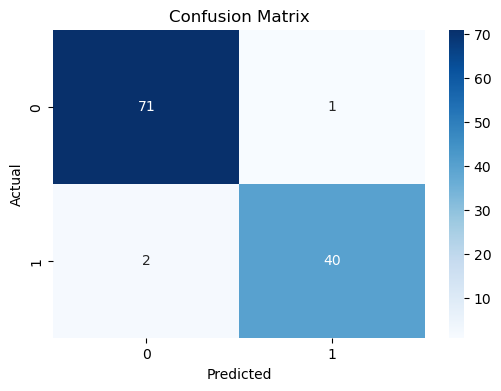

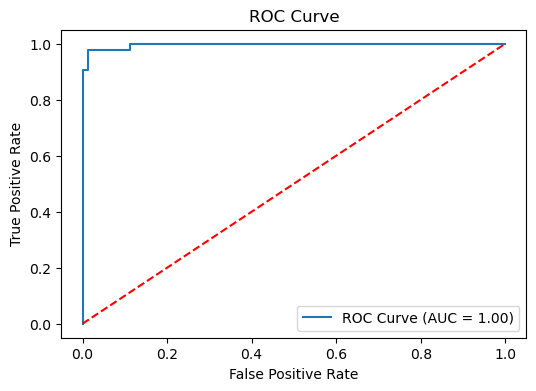


Feature Importance:
 area_worst                 3.555981
radius_se                  2.589263
texture_worst              2.086928
concave points_mean        1.956192
concavity_worst            1.037834
compactness_se             1.001865
texture_se                 0.686956
symmetry_worst             0.662294
concave points_worst       0.351174
smoothness_se              0.349766
radius_worst               0.298762
fractal_dimension_se       0.253624
smoothness_worst           0.245696
concave points_se          0.125982
compactness_worst          0.000000
perimeter_worst            0.000000
symmetry_se                0.000000
radius_mean                0.000000
concavity_se               0.000000
texture_mean               0.000000
area_se                    0.000000
perimeter_se               0.000000
fractal_dimension_mean     0.000000
symmetry_mean              0.000000
concavity_mean             0.000000
compactness_mean           0.000000
smoothness_mean            0.000000
area_m

C:\Users\Xiaomi\AppData\Local\Temp\ipykernel_30220\3537833906.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.index, y=feature_importance.values, palette="viridis")


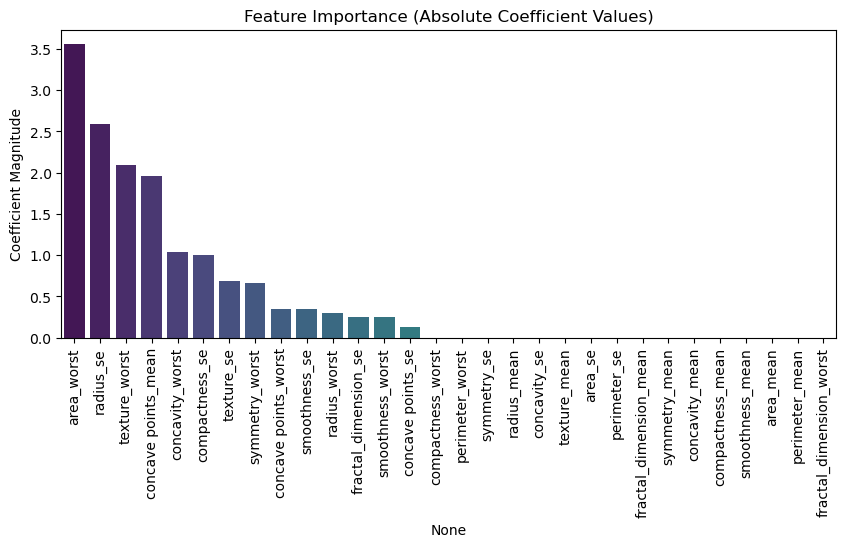


Top 5 features contributing most to predictions:
 area_worst             3.555981
radius_se              2.589263
texture_worst          2.086928
concave points_mean    1.956192
concavity_worst        1.037834
dtype: float64


In [11]:


# Step 1: Load Medical Data
data = pd.read_csv('breast_cancerdata.csv')

# Drop any extra unnamed columns (often created as index)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

print("Dataset Shape:", data.shape)
print("First 5 rows:\n", data.head())
print("\nColumns:", data.columns.tolist())
print("\nDescriptive Statistics:\n", data.describe())

# Step 2: Data Cleaning
# Check for missing values
print("\nMissing Values per Column:\n", data.isnull().sum())

# If an 'id' column exists, drop it
if 'id' in data.columns:
    data = data.drop('id', axis=1)

# Convert target column 'diagnosis' to binary:
# Assume 'B' for benign (0) and 'M' for malignant (1)
data['diagnosis'] = data['diagnosis'].map({'B': 0, 'M': 1})
print("\nTarget Distribution (0: Benign, 1: Malignant):\n", data['diagnosis'].value_counts())

# Separate features and target
X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

# Step 3: Handle Missing Values using Imputation
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Step 4: Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Step 5: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 6: Train Model using Logistic Regression (L1 regularization, solver='liblinear')
model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
model.fit(X_train, y_train)

# Step 7: Evaluate the Model
y_pred = model.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# ROC Curve and AUC Score
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc))
plt.plot([0,1], [0,1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Step 8: Insights - Feature Importance
# Feature importance from the absolute value of model coefficients
# Note: Ab X.columns ki length ab updated DataFrame se match karegi
feature_importance = pd.Series(np.abs(model.coef_[0]), index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)
print("\nFeature Importance:\n", feature_importance)

plt.figure(figsize=(10,4))
sns.barplot(x=feature_importance.index, y=feature_importance.values, palette="viridis")
plt.title("Feature Importance (Absolute Coefficient Values)")
plt.xticks(rotation=90)
plt.ylabel("Coefficient Magnitude")
plt.show()

# Identify and print top 5 features contributing most to predictions
top_features = feature_importance.head(5)
print("\nTop 5 features contributing most to predictions:\n", top_features)
